In [1]:
models = []

## Modules and data preparation

In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=72, include_cur_row: bool=False):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
        
    res_df = (df - df_roll.mean()) / df_roll.std()
    res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[days_range:] #

## LightGBM classification

In [4]:
import lightgbm as lgb

path = "../../data/test.csv" #data_1h_with_features_ver02
df = pd.read_csv(path) 

if path == "../../data/test.csv":
    days_ranges = [4,8,12,16,20,24,36,48,72,96]
    price_types = ["close", "high", "low", "open"]
    features = ["SMA", "EMA", "WMA", "RSI", "HMA", "TEMA", "DEMA"]


    df.drop(columns=["Time_UTC_Start"], inplace=True)

    for i in range(len(days_ranges)-1):
        for j in range(i+1, len(days_ranges)):
            for price_type in price_types:
                for feature in features:
                    new_col_name = "diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
                    numerator_col_name = price_type+"_"+feature+str(days_ranges[i])
                    denominator_col_name = price_type+"_"+feature+str(days_ranges[j])
                    df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    for days_range in days_ranges:
        for price_type1 in price_types:
            for price_type2 in price_types:
                for feature in features:
                    new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)
                    numerator_col_name = price_type1
                    denominator_col_name = price_type2+"_"+feature+str(days_range)
                    df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    # for feature in ["CCI", "BOP", "ADX", "ATR", "MFI"]:
    #     for i in range(len(days_ranges)-1): 
    #         for j in range(i+1, len(days_ranges)):
    #             new_col_name = "diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
    #             numerator_col_name = feature+str(days_ranges[i])
    #             denominator_col_name = feature+str(days_ranges[j])
    #             df[new_col_name] = df[numerator_col_name]/df[denominator_col_name]-1


    for i in range(1,5):
        a = df[["VWAP","volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]].shift(i)
        a.columns += str(i)
        df = pd.concat((df, a), axis=1)
        for price_type1 in price_types:
            for price_type2 in price_types:
                new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_price_" + str(i) + "_ago"
                numerator_col_name = price_type1
                denominator_col_name = price_type2
                df[new_col_name] =  np.log(df[numerator_col_name]/df[denominator_col_name].shift(i))


    df.dropna(inplace=True)

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])
/tmp/ipykernel_26798/3946004409.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [5]:
if path == "../../data/data_1h_with_features_ver02.csv":
    days_ranges = [4,8,12,16,20,24,48,72]
    price_types = ["close", "high", "low", "open"]
    features = ["price_SMA", "price_EMA", "price_WMA", "RSI"]


    df.drop(columns=["Time_UTC_Start"], inplace=True)

    for i in range(len(days_ranges)-1):
        for j in range(i+1, len(days_ranges)):
            for price_type in price_types:
                for feature in features:
                    new_col_name = "diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
                    numerator_col_name = price_type+"_"+feature+str(days_ranges[i])
                    denominator_col_name = price_type+"_"+feature+str(days_ranges[j])
                    df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    for days_range in days_ranges:
        for price_type1 in price_types:
            for price_type2 in price_types:
                for feature in features:
                    new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)
                    numerator_col_name = price_type1
                    denominator_col_name = price_type2+"_"+feature+str(days_range)
                    df[new_col_name] = np.log(df[numerator_col_name]/df[denominator_col_name])


    for feature in ["CCI", "BOP", "ADX", "ATR", "MFI"]:
        for i in range(len(days_ranges)-1): 
            for j in range(i+1, len(days_ranges)):
                new_col_name = "diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])
                numerator_col_name = feature+str(days_ranges[i])
                denominator_col_name = feature+str(days_ranges[j])
                df[new_col_name] = df[numerator_col_name]/df[denominator_col_name]-1


    for i in range(1,5):
        a = df[["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]].shift(i)
        a.columns += str(i)
        df = pd.concat((df, a), axis=1)
        for price_type1 in price_types:
            for price_type2 in price_types:
                new_col_name = "diff_cur_" + price_type1 + "_price-" + price_type2 + "_price_" + str(i) + "_ago"
                numerator_col_name = price_type1
                denominator_col_name = price_type2
                df[new_col_name] =  np.log(df[numerator_col_name]/df[denominator_col_name].shift(i))
        

In [6]:
df.ffill(inplace=True)
df.isna().any().sum()

0

In [7]:
if path != "../../data/data_1h_with_features_ver02.csv":
    df.drop(columns=['KST', 'MACD', 'VTX12', 'VTX16', 'VTX20', 'VTX24', 'VTX36', 'VTX4',
           'VTX48', 'VTX72', 'VTX8', 'VTX96', "Unnamed: 0"], inplace=True)

In [8]:
# ori_df = df.copy()
# ori_df.head(2)

In [9]:
# Consider only diff columns
# if True:
#     diff_columns = []

#     for col in df.columns:
#         if "label" in col or ("diff" in col and "MA" in col):
#             diff_columns.append(col)

#     df = df[diff_columns]
    
# df.drop(columns=["close_price_diff", "high_price_diff", "low_price_diff", "open_price_diff"], inplace=True)

In [10]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [14]:
df.reset_index(drop=True, inplace=True)
df["label"] = df["close"] - df["close"].shift(1) >= 0
X = df.drop(columns=["label"])
X = X.iloc[:-1,:]
y = df["label"].shift(-1)[1:]
y.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

i = 20

diff_col = []

for c in X_train.columns:
    if "diff" in c:
        diff_col.append(c)
        
diff_col = []
for c in X_train.columns:
    if "diff" in c:
        diff_col.append(c)
        
X_train.loc[i:, ~X_train.columns.isin(diff_col)] = data_normalization(X_train.loc[:, ~X_train.columns.isin(diff_col)])
X_val.loc[i:, ~X_val.columns.isin(diff_col)] = data_normalization(X_val.loc[:, ~X_val.columns.isin(diff_col)])
X_test.loc[i:, ~X_test.columns.isin(diff_col)] = data_normalization(X_test.loc[:, ~X_test.columns.isin(diff_col)])

X_train = X_train[i:]
X_val = X_val[i:]
X_test = X_test[i:]

y_train = y_train[i:]
y_val = y_val[i:]
y_test = y_test[i:]

depth = 3
rate = 0.6
lr = 0.01

train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_val, y_val, reference=train_data)

params = {'objective': 'binary',
                      'metric': ['auc'],
                      'boosting':'dart',
                      'num_boost_round':1500,
                      'early_stopping_round': 100,
                      'learning_rate': lr,
                      'max_depth': depth,
                      'n_jobs': -1,
                      'min_data_in_leaf': int(df.shape[0]*0.01),
                      'num_leaves': 2**depth-1,
                      'feature_fraction': rate,
                      'extra_trees': True,
                      'verbosity': 1}

print(params)

model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

predicted_y = model.predict(X_test).reshape(-1,1)
target_y = y_test.to_numpy().reshape(-1,1)

transformed_predicted_y = Binarizer(threshold=0.5).fit_transform(predicted_y)

print(classification_report(target_y, transformed_predicted_y))
print("Confusion matrix:\n", confusion_matrix(target_y, transformed_predicted_y))

acc = accuracy_score(target_y, transformed_predicted_y)
print("Accuracy:", acc)

models.append(model)

ValueError: Found input variables with inconsistent numbers of samples: [33040, 33039]

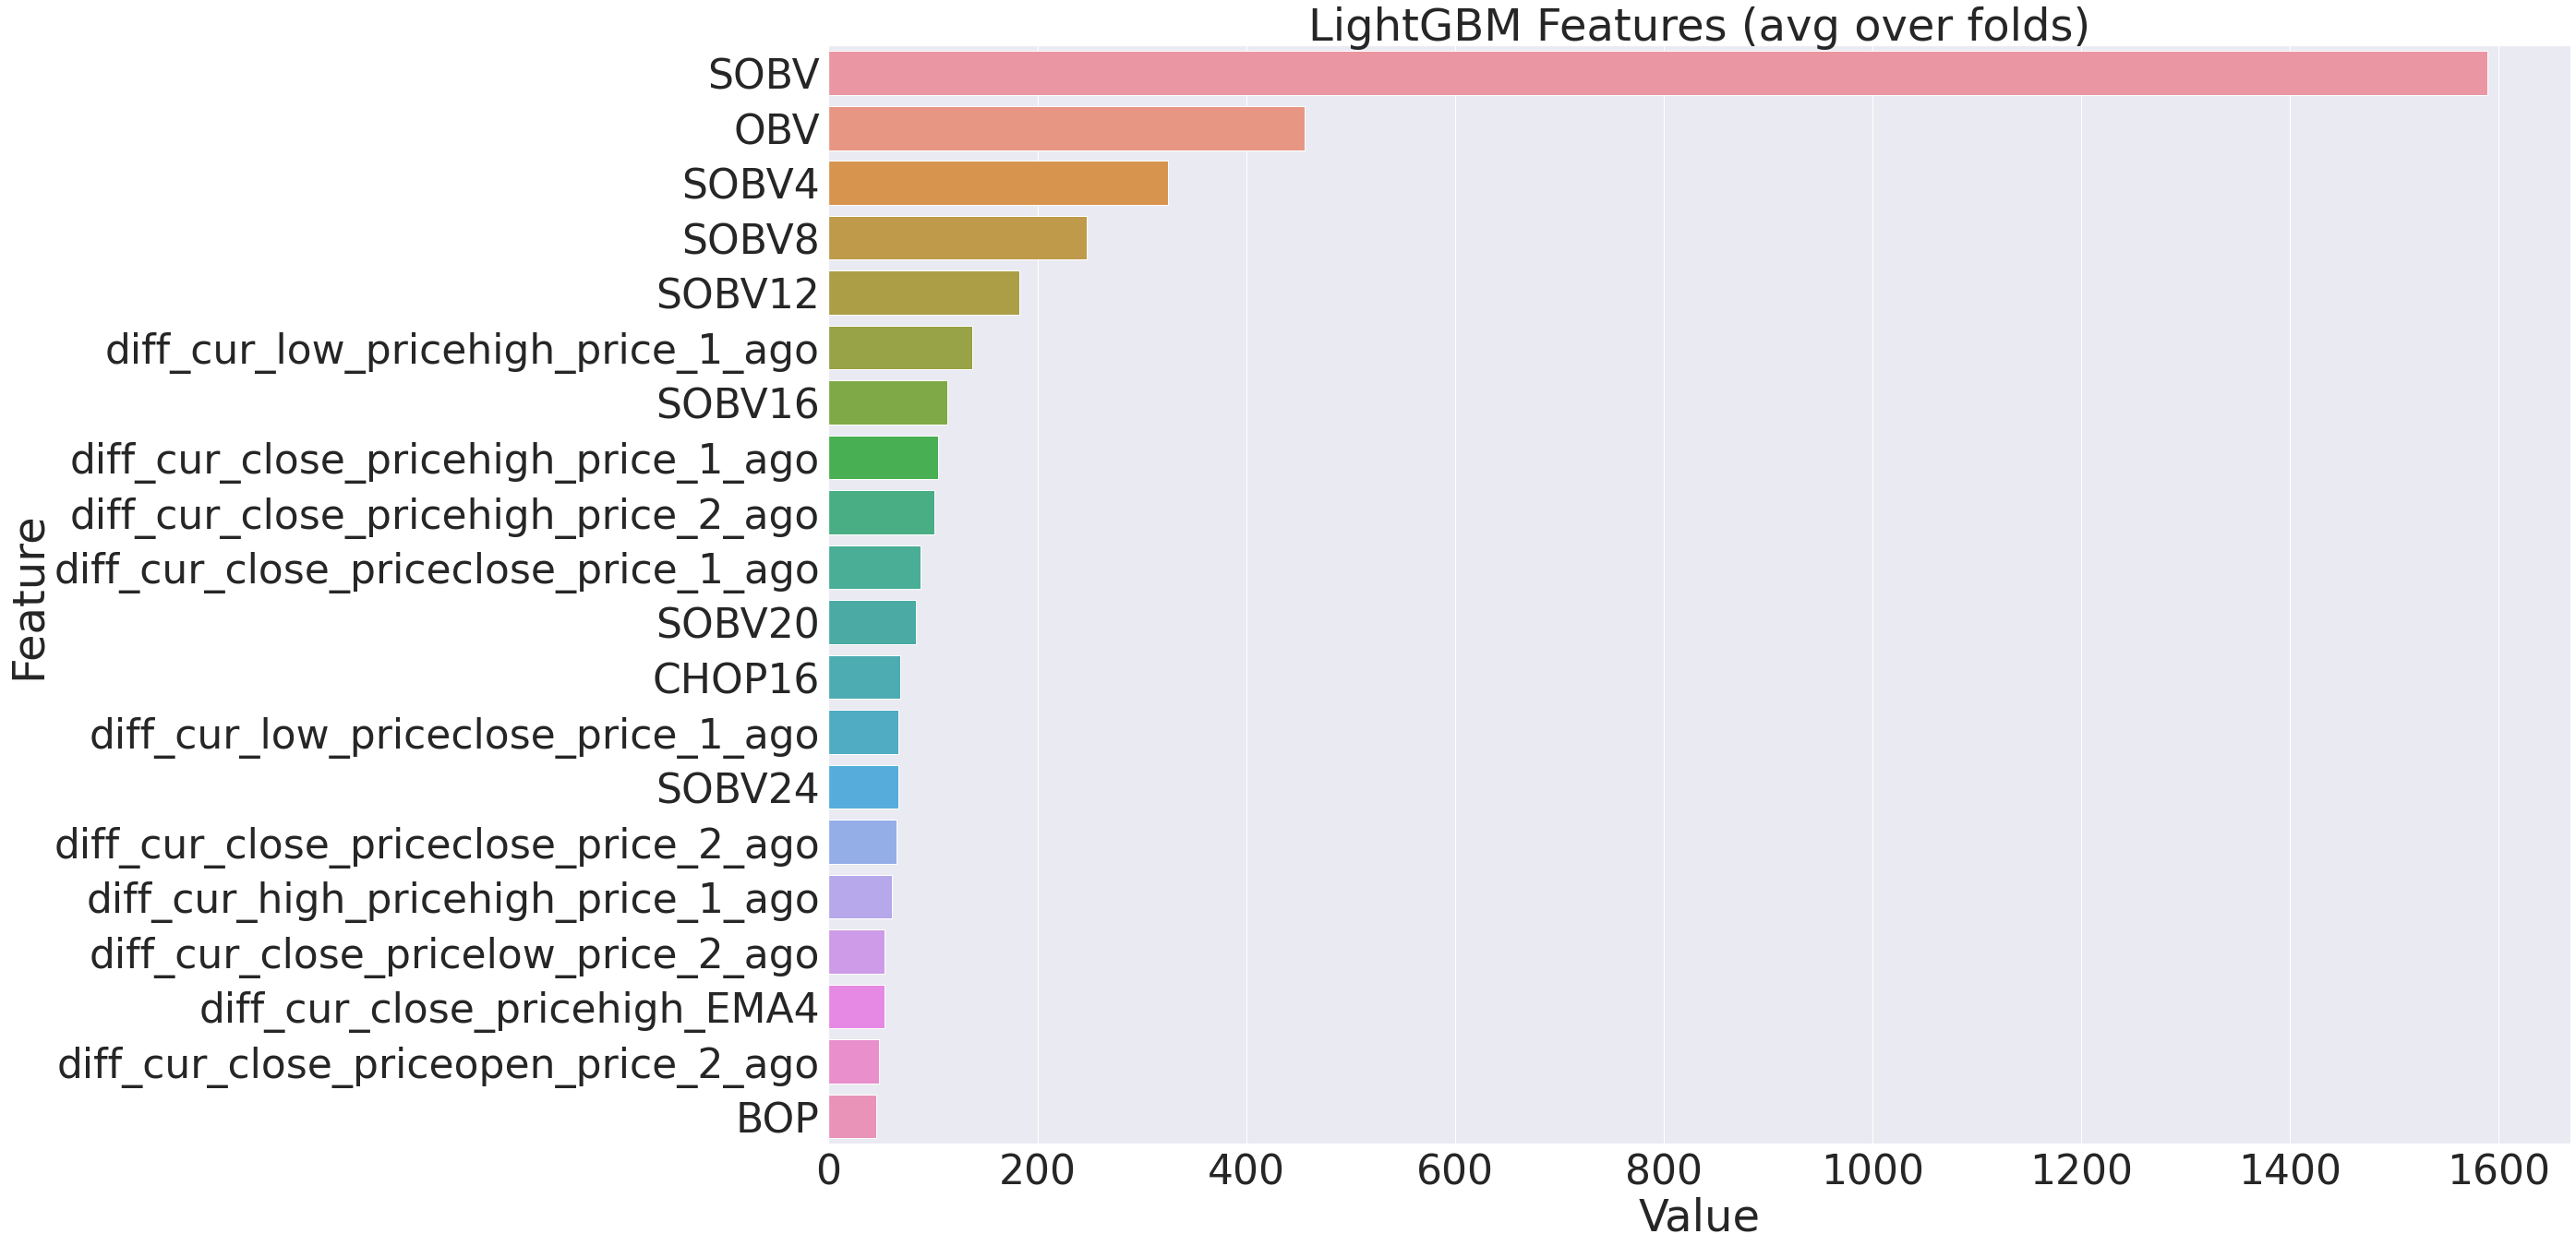

In [12]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
plotImp(model, X_test)

In [13]:
a = models[0].predict(X_test) >= 0.5
b = models[1].predict(X_test) >= 0.5
d = models[2].predict(X_test) >= 0.5
e = models[3].predict(X_test) >= 0.5

IndexError: list index out of range

In [ ]:
c = a&b&d&e
true_c = 0
count = 0

for i in range(c.shape[0]):
    if c[i] == True:
        true_c += 1
        if y_test.reset_index(drop=True)[i] == 1:
            count += 1
    else:
        c[i] = -1.0

In [ ]:
print(count, true_c)
count/true_c

In [ ]:
a = models[0].predict(X_test) < 0.5
b = models[1].predict(X_test) < 0.5
d = models[2].predict(X_test) < 0.5
e = models[3].predict(X_test) < 0.5

In [ ]:
c = a&b&d&e
true_c = 0
count = 0

for i in range(c.shape[0]):
    if c[i] == True:
        true_c += 1
        if y_test.reset_index(drop=True)[i] == 0:
            count += 1
    else:
        c[i] = -1.0

In [ ]:
print(count, true_c)
count/true_c

In [ ]:
(2001 + 1666)/(3397 + 2998)